### Import libraries

In [12]:
import numpy as np
import torch
import os
import importlib
import cv2
from PIL import Image
from argparse import ArgumentParser

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize
from torchvision.transforms import ToTensor, ToPILImage

from dataset import cityscapes
from erfnet import Net
from transform import Relabel, ToLabel, Colorize
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 3
HEIGHT = 512
WIDTH = 904


In [3]:
assert os.path.exists("erfnet" + ".py"), "Error: model definition not found"
model_file = importlib.import_module("erfnet")
model = model_file.Net(NUM_CLASSES)
model = torch.nn.DataParallel(model).cuda()

#### Load weights

In [4]:
model.load_state_dict(torch.load("../save/model_best.pth"))

<All keys matched successfully>

In [5]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(12,6))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

In [6]:
def color_lanes(image, classes, i, color, HEIGHT, WIDTH):
    buffer_c1 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c1[classes == i] = color[0]
    image[:, :, 0] += buffer_c1
    buffer_c2 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c2[classes == i] = color[1]
    image[:, :, 1] += buffer_c2
    buffer_c3 = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    buffer_c3[classes == i] = color[2]
    image[:, :, 2] += buffer_c3
    return image

In [9]:
def predict(img, model):
    
    op_transforms = Compose([ToTensor()])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    im_tensor = torch.unsqueeze(op_transforms(img), dim=0)
    im_tensor = im_tensor.to(device)
    model = model.to(device)
    model = model.eval()
    out = model(im_tensor)
    out = out.max(dim=1)[1]
    out_np = out.cpu().numpy()[0]
    return out_np

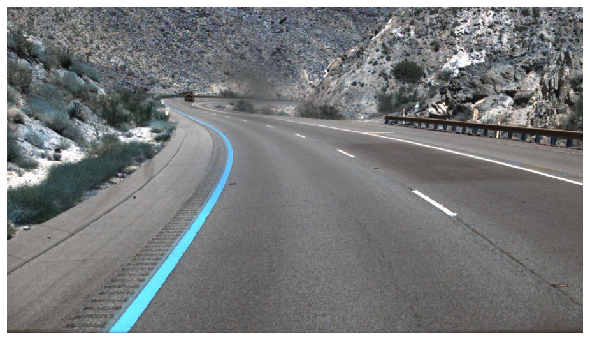

In [59]:
img = cv2.imread('../train/test_data_3/data/108.jpg') 
img = cv2.resize(img,(WIDTH, HEIGHT))
plot_img(img)

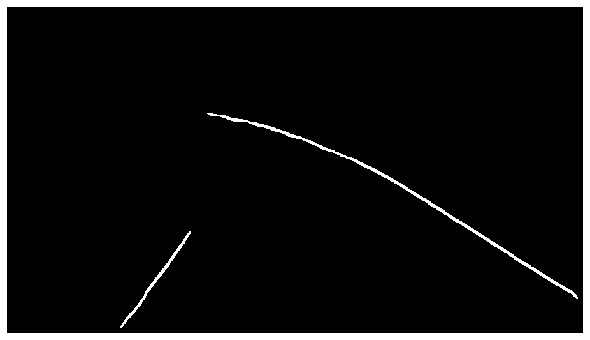

In [60]:
plot_img(predict(img, model))

In [64]:
pred = predict(img, model)

In [69]:
out_viz = np.zeros((HEIGHT, WIDTH, 3))
for i in range(5):
    rand_c1 = np.random.randint(1, 255)
    rand_c2 = np.random.randint(1, 255)
    rand_c3 = np.random.randint(1, 255)
    out_viz = color_lanes(out_viz, pred, i, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH)


In [70]:
instance_im = out_viz.astype(np.uint8)
im_seg = cv2.addWeighted(img, 1, instance_im, 1, 0)

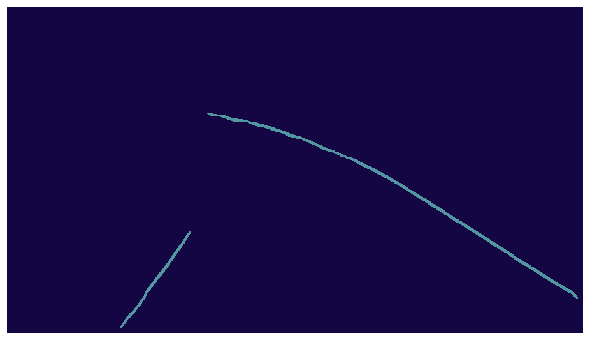

In [71]:
plot_img(instance_im)

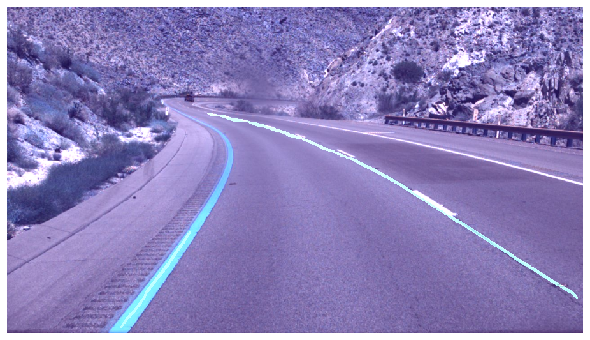

In [72]:
plot_img(im_seg)

### Processing with logs to obtain graphics of losses

In [49]:
with open("..//train//log.txt", "r") as f:
    mystr = f.readlines()
    loss_list = []
    val_loss_list = []
    for i in mystr:
        if i.startswith('loss:'):
            loss_list.append(float(i.split()[1]))
        elif i.startswith('VAL loss:'):
            val_loss_list.append(float(i.split()[2]))
len(loss_list), len(val_loss_list)

(1500, 1000)

Text(0, 0.5, 'loss')

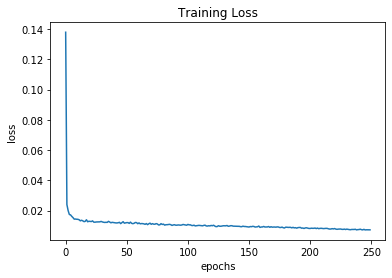

In [52]:
plt.plot(loss_list[1:750:3])
plt.title("Training Loss")
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

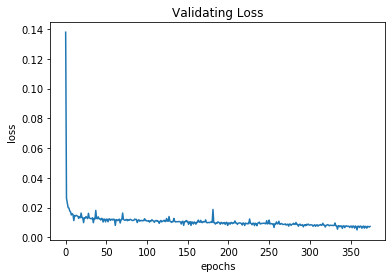

In [53]:
plt.plot(loss_list[1:750:2])
plt.title("Validating Loss")
plt.xlabel('epochs')
plt.ylabel('loss')